# Autograd in MinPy

Writing backprop is often the most tedious and error prone part of a deep net implementation. In fact, the feature of autograd has wide applications and goes beyond the domain of deep learning. MinPy's autograd applies to any NumPy code that is imperatively programmed. Moreover, it is seemlessly integrated with MXNet's symbolic program (see <a href="http://minpy.readthedocs.io/en/latest/tutorial/complete_sol_opt_guide/complete.html">for example</a>). By using MXNet's execution engine, all operations can be executed in GPU if available.

## A Close Look at Autograd System
MinPy's implementation of autograd is insprired from the <a href="https://github.com/HIPS/autograd"> Autograd project</a>. It computes a gradient function for any single-output function. For example, we define a simple function `foo`:

In [1]:
def foo(x):
    return x**2

foo(4)

16

Now we want to get its derivative. To do so, simply import `grad` from `minpy.core`.

In [2]:
import minpy.numpy as np  # currently need import this at the same time
from minpy.core import grad

d_foo = grad(foo)

In [3]:
d_foo(4)

8.0

You can also differentiate as many times as you want:

In [4]:
d_2_foo = grad(d_foo)
d_3_foo = grad(d_foo)

Now import `matplotlib` to visualize the derivatives.

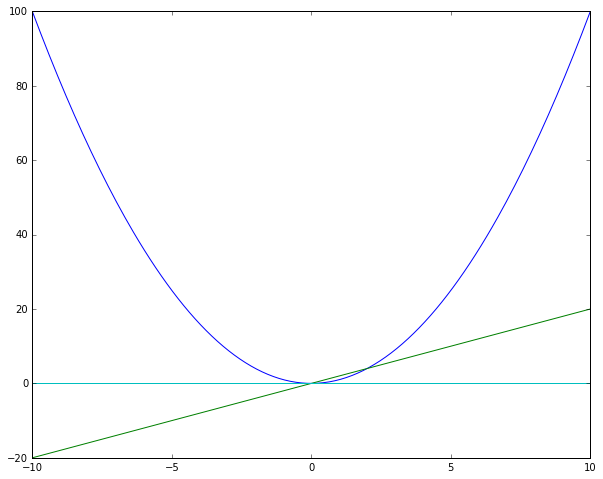

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

x = np.linspace(-10, 10, 200)
# plt.plot only takes ndarray as input. Explicitly convert MinPy Array into ndarray.
plt.plot(x.asnumpy(), foo(x).asnumpy(),
         x.asnumpy(), d_foo(x).asnumpy(),
         x.asnumpy(), d_2_foo(x).asnumpy(),
         x.asnumpy(), d_3_foo(x).asnumpy())
plt.show()

Just as you expected.

Autograd also differentiates vector inputs. For example:

In [6]:
x = np.array([1, 2, 3, 4])
d_foo(x)

[ 2.  4.  6.  8.]

## Gradient of Multivariate Functions
As for multivariate functions, you also need to specify arguments for derivative calculation. Only the specified argument will be calcualted. Just pass the position of the target argument (of a list of arguments) in `grad`. For example:

In [7]:
def bar(a, b, c):
    return 3*a + b**2 - c

We get their gradients by specifying their argument position.

In [8]:
gradient = grad(bar, [0, 1, 2])
grad_array = gradient(2, 3, 4)
print grad_array

[3.0, 6.0, -1.0]


`grad_array[0]`, `grad_array[1]`, and `grad_array[2]` are gradients of argument `a`, `b`, and `c`.

The following section will introduce a more comprehensive example on matrix calculus.

## Autograd for Loss Function

Since in world of machine learning we optimize a scalar loss, Autograd is particular useful to obtain the gradient of input parameters for next updates. For example, we define an affine layer, relu layer, and a softmax loss. Before dive into this section, please see [Logistic regression tutorial](../get_started/logistic_regression.rst) first for a simpler application of Autograd.

In [9]:
def affine(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.
    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.
    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)
    Returns a tuple of:
    - out: output, of shape (N, M)
    """
    out = np.dot(x, w) + b
    return out

def relu(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).
    Input:
    - x: Inputs, of any shape
    Returns a tuple of:
    - out: Output, of the same shape as x
    """
    out = np.maximum(0, x)
    return out

def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.
    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C
    Returns a tuple of:
    - loss: Scalar giving the loss
    """
    N = x.shape[0]
    C = x.shape[1]
    probs = np.exp(x - np.max(x, axis=1, keepdims=True))
    probs = probs / np.sum(probs, axis=1, keepdims=True)
    loss = -np.sum(np.log(probs) * y) / N
    return loss

Then we use these layers to define a single layer fully-connected network, with a softmax output.

In [10]:
class SimpleNet(object):
    def __init__(self, input_size=100, num_class=3):
        # Define model parameters.
        self.params = {}
        self.params['w'] = np.random.randn(hidden_size, num_class) * 0.01
        self.params['b'] = np.zeros((1, 1))  # don't use int(1) (int cannot track gradient info)

    def forward(self, X):
        # First affine layer (fully-connected layer).
        y1 = affine(X, self.params['w'], self.params['b'])
        # ReLU activation.
        y2 = relu(y1)
        return y1

    def loss(self, X, y):
        # Compute softmax loss between the output and the label.
        return softmax_loss(self.forward(X), y)

We define some hyperparameters.

In [11]:
batch_size = 100
input_size = 50
hidden_size = 100
num_class = 3

Here is the net and data.

In [12]:
net = SimpleNet(hidden_size, num_class)
x = np.random.randn(batch_size, hidden_size)
y0 = np.random.randint(0, 3, size=batch_size)
y = np.zeros((batch_size, num_class))
y[np.arange(batch_size), y0] = 1

Now get gradients.

In [13]:
gradient = grad(net.loss)

Then we can get gradient by simply call `gradient(X, y)`.

In [14]:
d_x = gradient(x, y)

Ok, Ok, I know you are not interested in `x`'s gradient. I will show you how to get the gradient of the parameters. First, you need to define a function with the parameters as the arguments for Autograd to process.

In [15]:
def loss_func(w, b, X, y):
    return net.loss(X, y)

Yes, you just need to provide an entry in the new function's parameter list for `w` and `b` and that's it! Now let's try to derive its gradient.

In [16]:
gradient = grad(loss_func, [0, 1])

Note that you need to specify a list for the parameters that you want their gradients.

Now we have

In [17]:
d_w, d_b = gradient(net.params['w'], net.params['b'], x, y)

With `d_w` and `d_b` in hand, training `net` is just a piece of cake.

## Less Calculation: Get Forward Pass and Backward Pass Simultaneously
Since gradient calculation in MinPy needs forward pass information, if you need the forward result and the gradient calculation at the same time, please use `grad_and_loss` to get them simultaneously. In fact, `grad` is just a wrapper of `grad_and_loss`. For example, we can get

In [18]:
from minpy.core import grad_and_loss
forward_backward = grad_and_loss(bar, [0, 1, 2])
grad_array, result = forward_backward(2, 3, 4)

`grad_array` and `result` are result of gradient and forward pass respectively.